In [1]:
import os 
import pandas as pd
import numpy as np

# import sklearn methods 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sys 
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred):
    str_out = ""
    str_out += ("TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    
    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

# RLDD DATA

The best parameters are {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 1} with a score of 0.7729
TEST SCORES

ACCURACY: 0.7723

CONFUSION MATRIX:
[[167951  17634  13299]
 [ 35867 136988  25465]
 [ 23093  21273 158527]]

FALSE POSITIVES:
35867 out of 172855 positive labels (0.2075%)

FALSE NEGATIVES:
17634 out of 185585 negative labels (0.0950%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79    198884
           1       0.78      0.69      0.73    198320
           2       0.80      0.78      0.79    202893

    accuracy                           0.77    600097
   macro avg       0.77      0.77      0.77    600097
weighted avg       0.77      0.77      0.77    600097



([<matplotlib.patches.Wedge at 0x7f484885d910>,
 [Text(-0.3762221603465247, 1.0336618818860421, 'n_EAR'),
  Text(-1.0999997319395896, 0.0007679406431471522, 'n_MAR'),
  Text(-0.1947932332724012, -1.082615165361766, 'n_MOE'),
  Text(0.5112128902956159, -0.9739924952460377, 'n_EC'),
  Text(1.0905559002453555, -0.1438326403847271, 'n_LEB'),
  Text(0.7849342825932444, 0.770634914865547, 'n_SOP'),
  Text(0.41337233721463296, 1.0193739798649522, 'PERCLOS'),
  Text(0.03672657502532917, 1.099386719351707, 'CLOSENESS')],
 [Text(-0.20521208746174074, 0.563815571937841, '11.11%'),
  Text(-0.5999998537852306, 0.0004188767144439012, '27.76%'),
  Text(-0.10625085451221881, -0.5905173629245996, '16.60%'),
  Text(0.27884339470669955, -0.531268633770566, '4.45%'),
  Text(0.594848672861103, -0.0784541674825784, '25.99%'),
  Text(0.4281459723235878, 0.42034631719938925, '2.89%'),
  Text(0.22547582029889068, 0.5560221708354284, '10.14%'),
  Text(0.02003267728654318, 0.5996654832827492, '1.06%')])

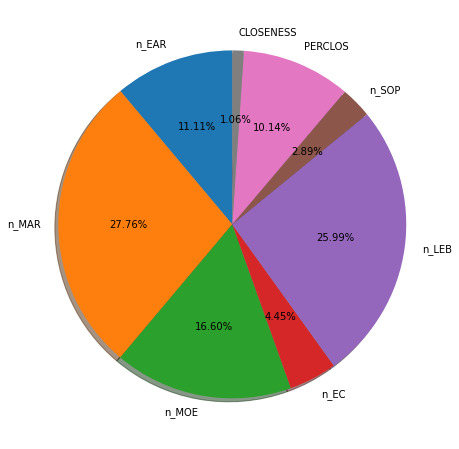

In [3]:
df_original = pd.read_pickle('../input/rlddandmerged/rldd_normalized_scaled.pkl')

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"].map({0: 0, 0.5: 1, 1:2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# cross-validation with 5 splits
cross_val = StratifiedShuffleSplit(n_splits=10, random_state = 42)

lgb_estimator = lgb.LGBMClassifier(random_state = 0,device= "gpu")

# parameters 
parameters = {  
                'reg_lambda': [0.1, 1, 10],
                'n_estimators': [300],
                'max_depth': [5, 10],
                'learning_rate':[0.001, 0.01, 0.1]
                }

# grid search for parameters
grid = GridSearchCV(estimator=lgb_estimator, param_grid=parameters, cv=cross_val, n_jobs=-1)#multithreading; all cores are used
grid.fit(X_train, y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

# prediction results
y_pred = grid.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(y_test, y_pred)
print(results)

# plot importances
labels = X_train.columns
plt.figure(figsize=(8,8))
plt.pie(grid.best_estimator_.feature_importances_, labels=labels, shadow=True, startangle=90, autopct='%1.2f%%') 